In [1]:
import lasio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prov import identifier

In [2]:
colors = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'yellow',
    5: 'orange',
    6: 'purple',
    7: 'cyan',
    8: 'magenta',
    9: 'lime',
    10: 'pink',
    11: 'teal',
    12: 'lavender',
    13: 'brown',
    14: 'maroon',
    15: 'olive'
}

In [3]:
DATA_DIR = "..\\data\\las"
EXCEL_DIR = "..\\data"

In [4]:
well_idx = []

In [5]:
for filename in os.listdir(DATA_DIR):
    # Print each filename
    well_idx.append(filename.split("_")[0])
    # print(filename)

In [6]:
well_idx = set(well_idx)

In [7]:
len(well_idx)

41

In [8]:
type(list(well_idx)[0])

str

In [9]:
excel = pd.read_excel(EXCEL_DIR + "\\Отбивки пласта АС11-2.xlsx")

In [10]:
upper_bounds = excel.iloc[::2].copy()
upper_bounds.rename(columns={'Z': 'upper'}, inplace=True)
upper_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [11]:
lower_bounds = excel.iloc[1::2].copy()
lower_bounds.rename(columns={'Z': 'lower'}, inplace=True)
lower_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [12]:
target_layers = pd.merge(upper_bounds, lower_bounds, on='Well identifier', how='outer')
target_layers['Well identifier'] = target_layers['Well identifier'].astype(str)
target_layers = target_layers[target_layers['Well identifier'].isin(well_idx)]


In [13]:
target_layers

,Well identifier,upper,lower
1,12,-2161.95,-2183.98
2,13,-2158.72,-2175.36
3,14,-2170.38,-2190.59
4,15,-2170.84,-2188.69
5,16,-2157.70,-2178.94
6,17,-2150.80,-2171.09
7,18,-2146.87,-2167.39
8,19,-2129.24,-2150.87
9,20,-2141.56,-2162.04
10,22,-2129.92,-2146.85


In [38]:
target_layers.iloc[30]

Well identifier         44
upper             -2128.99
lower             -2145.62
Name: 32, dtype: object

In [52]:
def view_well(selected_well, target_layers=target_layers):
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[selected_well]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[selected_well].upper) & (las['Z'] > target_layers.iloc[selected_well].lower))
    las_dis = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[selected_well]['Well identifier']}_discrete.las"))
    target_layer_idx_dis = np.where((las_dis['Z'] < target_layers.iloc[selected_well].upper) & (las_dis['Z'] > target_layers.iloc[selected_well].lower))
    background_ranges = las_dis['Z'][target_layer_idx_dis]
    background_ranges = np.append(background_ranges, las['Z'][target_layer_idx][-1])
    background_ranges = np.insert(background_ranges, 0, las['Z'][target_layer_idx][0])

    background_ranges = np.vstack((background_ranges[:-1], background_ranges[1:])).T

    background_colors = None
    try:
        background_colors = [colors[key] for key in las_dis['FACIES'][np.insert(target_layer_idx_dis, 0, target_layer_idx_dis[0][0]-1)].astype(int)]
    except KeyError:
        print('Probably not enough rows in discrete file, check number ', target_layers.iloc[selected_well]['Well identifier'])
    except IndexError:
        print('Only one discrete layer in well ' + target_layers.iloc[selected_well]['Well identifier'])
    
    plt.figure(figsize=(20, 4))
    plt.subplot(121)
    try:
        plt.plot(las["Z"][target_layer_idx], las["NEU"][target_layer_idx])
    except KeyError:
        print("No NEU measurements in target layer")
    if background_colors is not None:
        for color, (start, end) in zip(background_colors, background_ranges):
            plt.axvspan(start, end, color=color, alpha=0.3)
    plt.xlabel("Z")
    plt.ylabel("NEU")
    
    plt.subplot(122)
    try:
        plt.plot(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx])
    except KeyError:
        print("No GGKP measurements in target layer")
    if background_colors is not None:    
        for color, (start, end) in zip(background_colors, background_ranges):
            plt.axvspan(start, end, color=color, alpha=0.3)
    plt.xlabel("Z")
    plt.ylabel("GGKP")
    
    plt.show()

Only one discrete layer in well 44
No NEU measurements in target layer


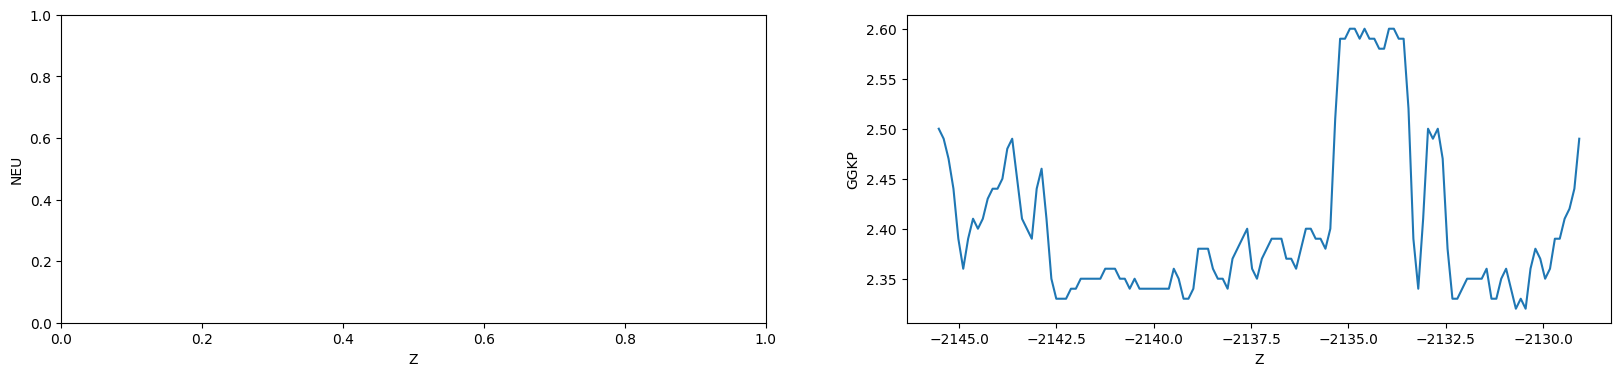

In [53]:
view_well(30)

30


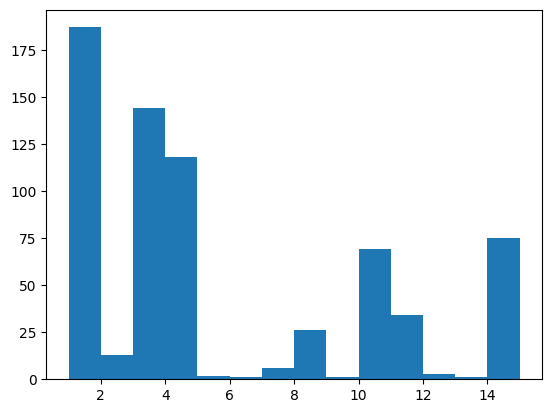

In [37]:
faceis = []

for well_index in range(len(well_idx)):
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    las_dis = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_discrete.las"))
    target_layer_idx_dis = np.where((las_dis['Z'] < target_layers.iloc[well_index].upper) & (las_dis['Z'] > target_layers.iloc[well_index].lower))
    try:
        faceis.extend(las_dis['FACIES'][np.insert(target_layer_idx_dis, 0, target_layer_idx_dis[0][0]-1)])
    except IndexError:
        print(well_index)
        
faceis = np.array(faceis)
faceis = faceis[~np.isnan(faceis)]

plt.hist(faceis, bins='doane')
plt.show()

мысль - свёртки

depth - длина по стволу - по кривой
sstvd - абсолютная переведённая
z - от моря
одна положительная другая отрицательная разницы нет
лучше либо 2 либо 3

ggkp - гамма каротаж - фоновое гамма излучение

отбивки - границы пласта(субгоризонтальная бурная порода) - точка входа и выхода из целевого пласта - остальное неинтересно
Z - тот же столбик
MD - глубина

дискретные файлы
facies - ручная разметка вручную
log9 - обонзачает то же самое, просто укрупленная, достаточно одной
когда пересекаем глубину начинается код N


neu - нейтронный каротаж - неважно? можно по одной, но с этой +



суть задачи

- кластеризация всех скважин в пределах пластов по форме гамма и второго каротажа
- дальше сложнее: кластеризация кусков формы внутри пласта. То есть каждый график разбить на кусочки - берутся из дискретности. Не
- - Не всегда размечены именно формы, какой-то информации у нас может не быть
- - Цель - не 100% совпадение с разметкой ручной
- - Скользящее окно не дало плодов, проблемы - шум, интересуют крупные, на каждую скважину не более 3

отобразить, посмотреть, обрезать по пласту, поискать основные формы, описаны в какой-тио методике - простейшие геометрические - коробки, пирамиды, воронки
по второй - сложно непонятно